In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np
import random

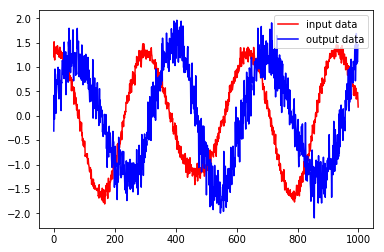

In [6]:
n_timesteps_in = 50 
n_timesteps_out = 40 

n_features_in = 1
n_features_out = 1

time_series_length = 1000
t = np.linspace(0, 10, time_series_length)

ts_input = np.sin(3*t) / 2 + 3 * np.cos(2*t) + 0.2 * np.random.standard_normal(size=time_series_length)
ts_input = np.reshape(ts_input, (1000, 1))
ts_output = np.cos(3*t) / 3 + 2 * np.sin(2*t) + 0.4 * np.random.standard_normal(size=time_series_length)
ts_output = np.reshape(ts_output, (1000, 1))

ts_input = StandardScaler().fit_transform(ts_input)
ts_output = StandardScaler().fit_transform(ts_output)


plt.plot(ts_input, 'r', label = 'input data')
plt.plot(ts_output,'b', label = 'output data')

plt.legend()

In [4]:
sliced_input = int(0.8*len(ts_input))
sliced_output = int(0.8*len(ts_output))

train_input = ts_input[:sliced_input]
test_input = ts_input[sliced_input:]

train_output = ts_output[:sliced_output]
test_output = ts_output[sliced_output:]

In [8]:
seq_len = max(n_timesteps_in, n_timesteps_out)

train_in = []
test_in = []

train_out = []
test_out = []

for i in range(500):
    rand_train = random.randint(0, len(train_input) - seq_len)
    in_seq = train_input[rand_train:rand_train+n_timesteps_in]
    out_seq = train_output[rand_train:rand_train+n_timesteps_out]

    train_in.append(in_seq)
    train_out.append(out_seq)
train_in, train_out = np.array(train_in), np.array(train_out)

for i in range(5):
    rand_test = random.randint(0, len(test_input) - seq_len)
    in_seq = test_input[rand_test:rand_test+n_timesteps_in]
    out_seq = test_output[rand_test:rand_test+n_timesteps_out]

    test_in.append(in_seq)
    test_out.append(out_seq)
test_in, test_out = np.array(test_in), np.array(test_out)

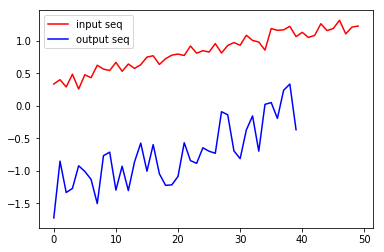

In [10]:
plt.plot(train_in[0], 'r', label = 'input seq')
plt.plot(train_out[0], 'b', label = 'output seq')
plt.legend()

In [11]:
train_in = np.reshape(train_in, (train_in.shape[0], n_timesteps_in, n_features_in))
train_out = np.reshape(train_out, (train_out.shape[0], n_timesteps_out, n_features_out))

test_in = np.reshape(test_in, (test_in.shape[0], n_timesteps_in, n_features_in))
test_out = np.reshape(test_out, (test_out.shape[0], n_timesteps_out, n_features_out))

n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        66560       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [14]:
model.compile(optimizer='adam', loss='mse')

decoder_inputs = np.zeros(train_out.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_in, decoder_inputs], train_out,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 7s - loss: 1.0230 - val_loss: 0.9518 - 7s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 0.9121 - val_loss: 0.8936 - 517ms/epoch - 74ms/step
Epoch 3/100
7/7 - 1s - loss: 0.8371 - val_loss: 0.9017 - 570ms/epoch - 81ms/step
Epoch 4/100
7/7 - 0s - loss: 0.6859 - val_loss: 0.4261 - 432ms/epoch - 62ms/step
Epoch 5/100
7/7 - 0s - loss: 0.3895 - val_loss: 0.3682 - 432ms/epoch - 62ms/step
Epoch 6/100
7/7 - 1s - loss: 0.3748 - val_loss: 0.3399 - 586ms/epoch - 84ms/step
Epoch 7/100
7/7 - 0s - loss: 0.3477 - val_loss: 0.3235 - 454ms/epoch - 65ms/step
Epoch 8/100
7/7 - 1s - loss: 0.2884 - val_loss: 0.3369 - 564ms/epoch - 81ms/step
Epoch 9/100
7/7 - 0s - loss: 0.2748 - val_loss: 0.2582 - 439ms/epoch - 63ms/step
Epoch 10/100
7/7 - 0s - loss: 0.2504 - val_loss: 0.2853 - 486ms/epoch - 69ms/step
Epoch 11/100
7/7 - 0s - loss: 0.2662 - val_loss: 0.2744 - 432ms/epoch - 62ms/step
Epoch 12/100
7/7 - 0s - loss: 0.2419 - val_loss: 0.2765 - 432ms/epoch - 62ms/step
Epoch 13/100
7/7 - 0s - loss: 

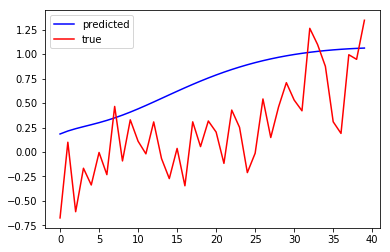

In [15]:
decoder_inputs = np.zeros(test_out.shape)
y_pred = model.predict([test_in, decoder_inputs])

plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_out[0], 'r', label = 'true')

plt.legend()

2)

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow_datasets as tfds

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape, InputLayer

import numpy as np
import random

In [24]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [57]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

dmodel = Sequential()
   
dmodel.add(Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)))
dmodel.add(LeakyReLU(alpha=0.2))
    
dmodel.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
dmodel.add(LeakyReLU(alpha=0.2))
  
dmodel.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
dmodel.add(LeakyReLU(alpha=0.2))
    
dmodel.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
dmodel.add(LeakyReLU(alpha=0.2))
   
dmodel.add(Flatten())
dmodel.add(Dropout(0.4))
dmodel.add(Dense(1, activation='sigmoid'))
    
dmodel.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

l_dim = 100

X_train_ = (X_train.astype(np.float32) - 127.5) / 127.5
X_train_ = np.reshape(X_train_, (X_train.shape[0], 28, 28, 1))
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) 
l_dim = 100
n_classes = len(labels)

g_chan = l_dim + n_classes

gmodel = Sequential()
   
n_nodes = 112 * 7 * 7
gmodel.add(Dense(n_nodes, input_dim=l_dim))
gmodel.add(LeakyReLU(alpha=0.2))
gmodel.add(Reshape((7, 7, 112)))
   
gmodel.add(Conv2DTranspose(128, (7,7), strides=(2,2), padding='same'))
gmodel.add(LeakyReLU(alpha=0.2))
    
gmodel.add(Conv2DTranspose(128, (7,7), strides=(2,2), padding='same'))
gmodel.add(LeakyReLU(alpha=0.2))
   
gmodel.add(Conv2D(1, (3,3), activation='tanh', padding='same
                  
dmodel.trainable = False
ggmodel = Sequential()
ggmodel.add(gmodel)
ggmodel.add(dmodel)
ggmodel.compile(loss='binary_crossentropy', optimizer=optim)

epoch:  0


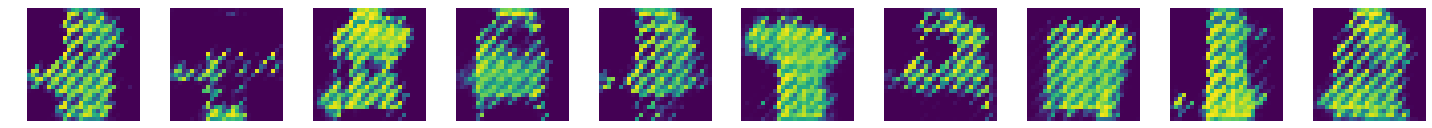

epoch:  10


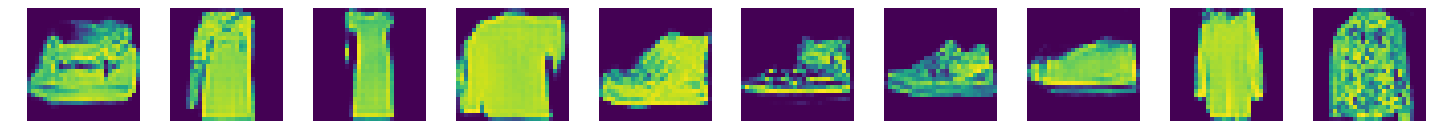

In [ ]:
epochs = 10 
batch_size = 128
d = []
num_batches = int(X_train_.shape[0]/batch_size)
for ep in range(epochs+1):
    for i in range(num_batches):
        noise = np.random.normal(0, 1, size=[batch_size, l_dim])
        image_batch = X_train_[np.random.randint(0, X_train_.shape[0], size=batch_size)]
               
        gen_im = generator.predict(noise)   
        X = np.concatenate([image_batch, gen_im])
  
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 0.9  
           
        dmodel.trainable = True
        d_loss, _ = dmodel.train_on_batch(X, y_dis)
        d.append(d_loss)
 
        noise = np.random.normal(0, 1, size=[batch_size, l_dim])
        y_gen = np.ones(batch_size)
        dmodel.trainable = False
        ggmodel.train_on_batch(noise, y_gen)
    if ep % 10 == 0:
        print('epoch: ', ep)
        num_of_images = 10
        noise = np.random.normal(0, 1, size=[num_of_images, l_dim])
        gen_im = gmodel.predict(noise)
        gen_im = np.reshape(gen_im, (gen_im.shape[0], 28, 28))
    
        gen_im = (gen_im + 1) / 2.0
    
        plt.figure(figsize=(30, 10))
        for i in range(num_of_images):
            plt.subplot(1, 10, i+1)
            plt.imshow(gen_im[i])
            plt.axis('off')
            plt.tight_layout()
        plt.show()